# Multi-Agent Resume Tailoring System
### Capstone Project - Google & Kaggle AI Agent Intensive Course

## Project Overview

This project implements a multi-agent system using Google's Agent Development Kit (ADK). The pipeline automates resume tailoring by combining:

1. **Resume Intake Agent** – extracts and standardizes resume content  
2. **Job Research Agent** – performs live search to identify real job requirements  
3. **Resume Rewrite Agent** – merges resume + job insights into a tailored final resume  
4. **Polishing Agent** – refines clarity, style, and conciseness

Each agent has a well-defined responsibility and hands its output to the next step. The final result is a fully rewritten, job-tailored resume with an explanation of the model’s decision-making process.

This project demonstrates how LLM-powered agents can collaborate to automate real-world workflows, remove ambiguity, and produce consistently high-quality results.

## System Architecture

The resume pipeline is implemented as a **sequential multi-agent system**, where each agent transforms the input and forwards structured output to the next stage.

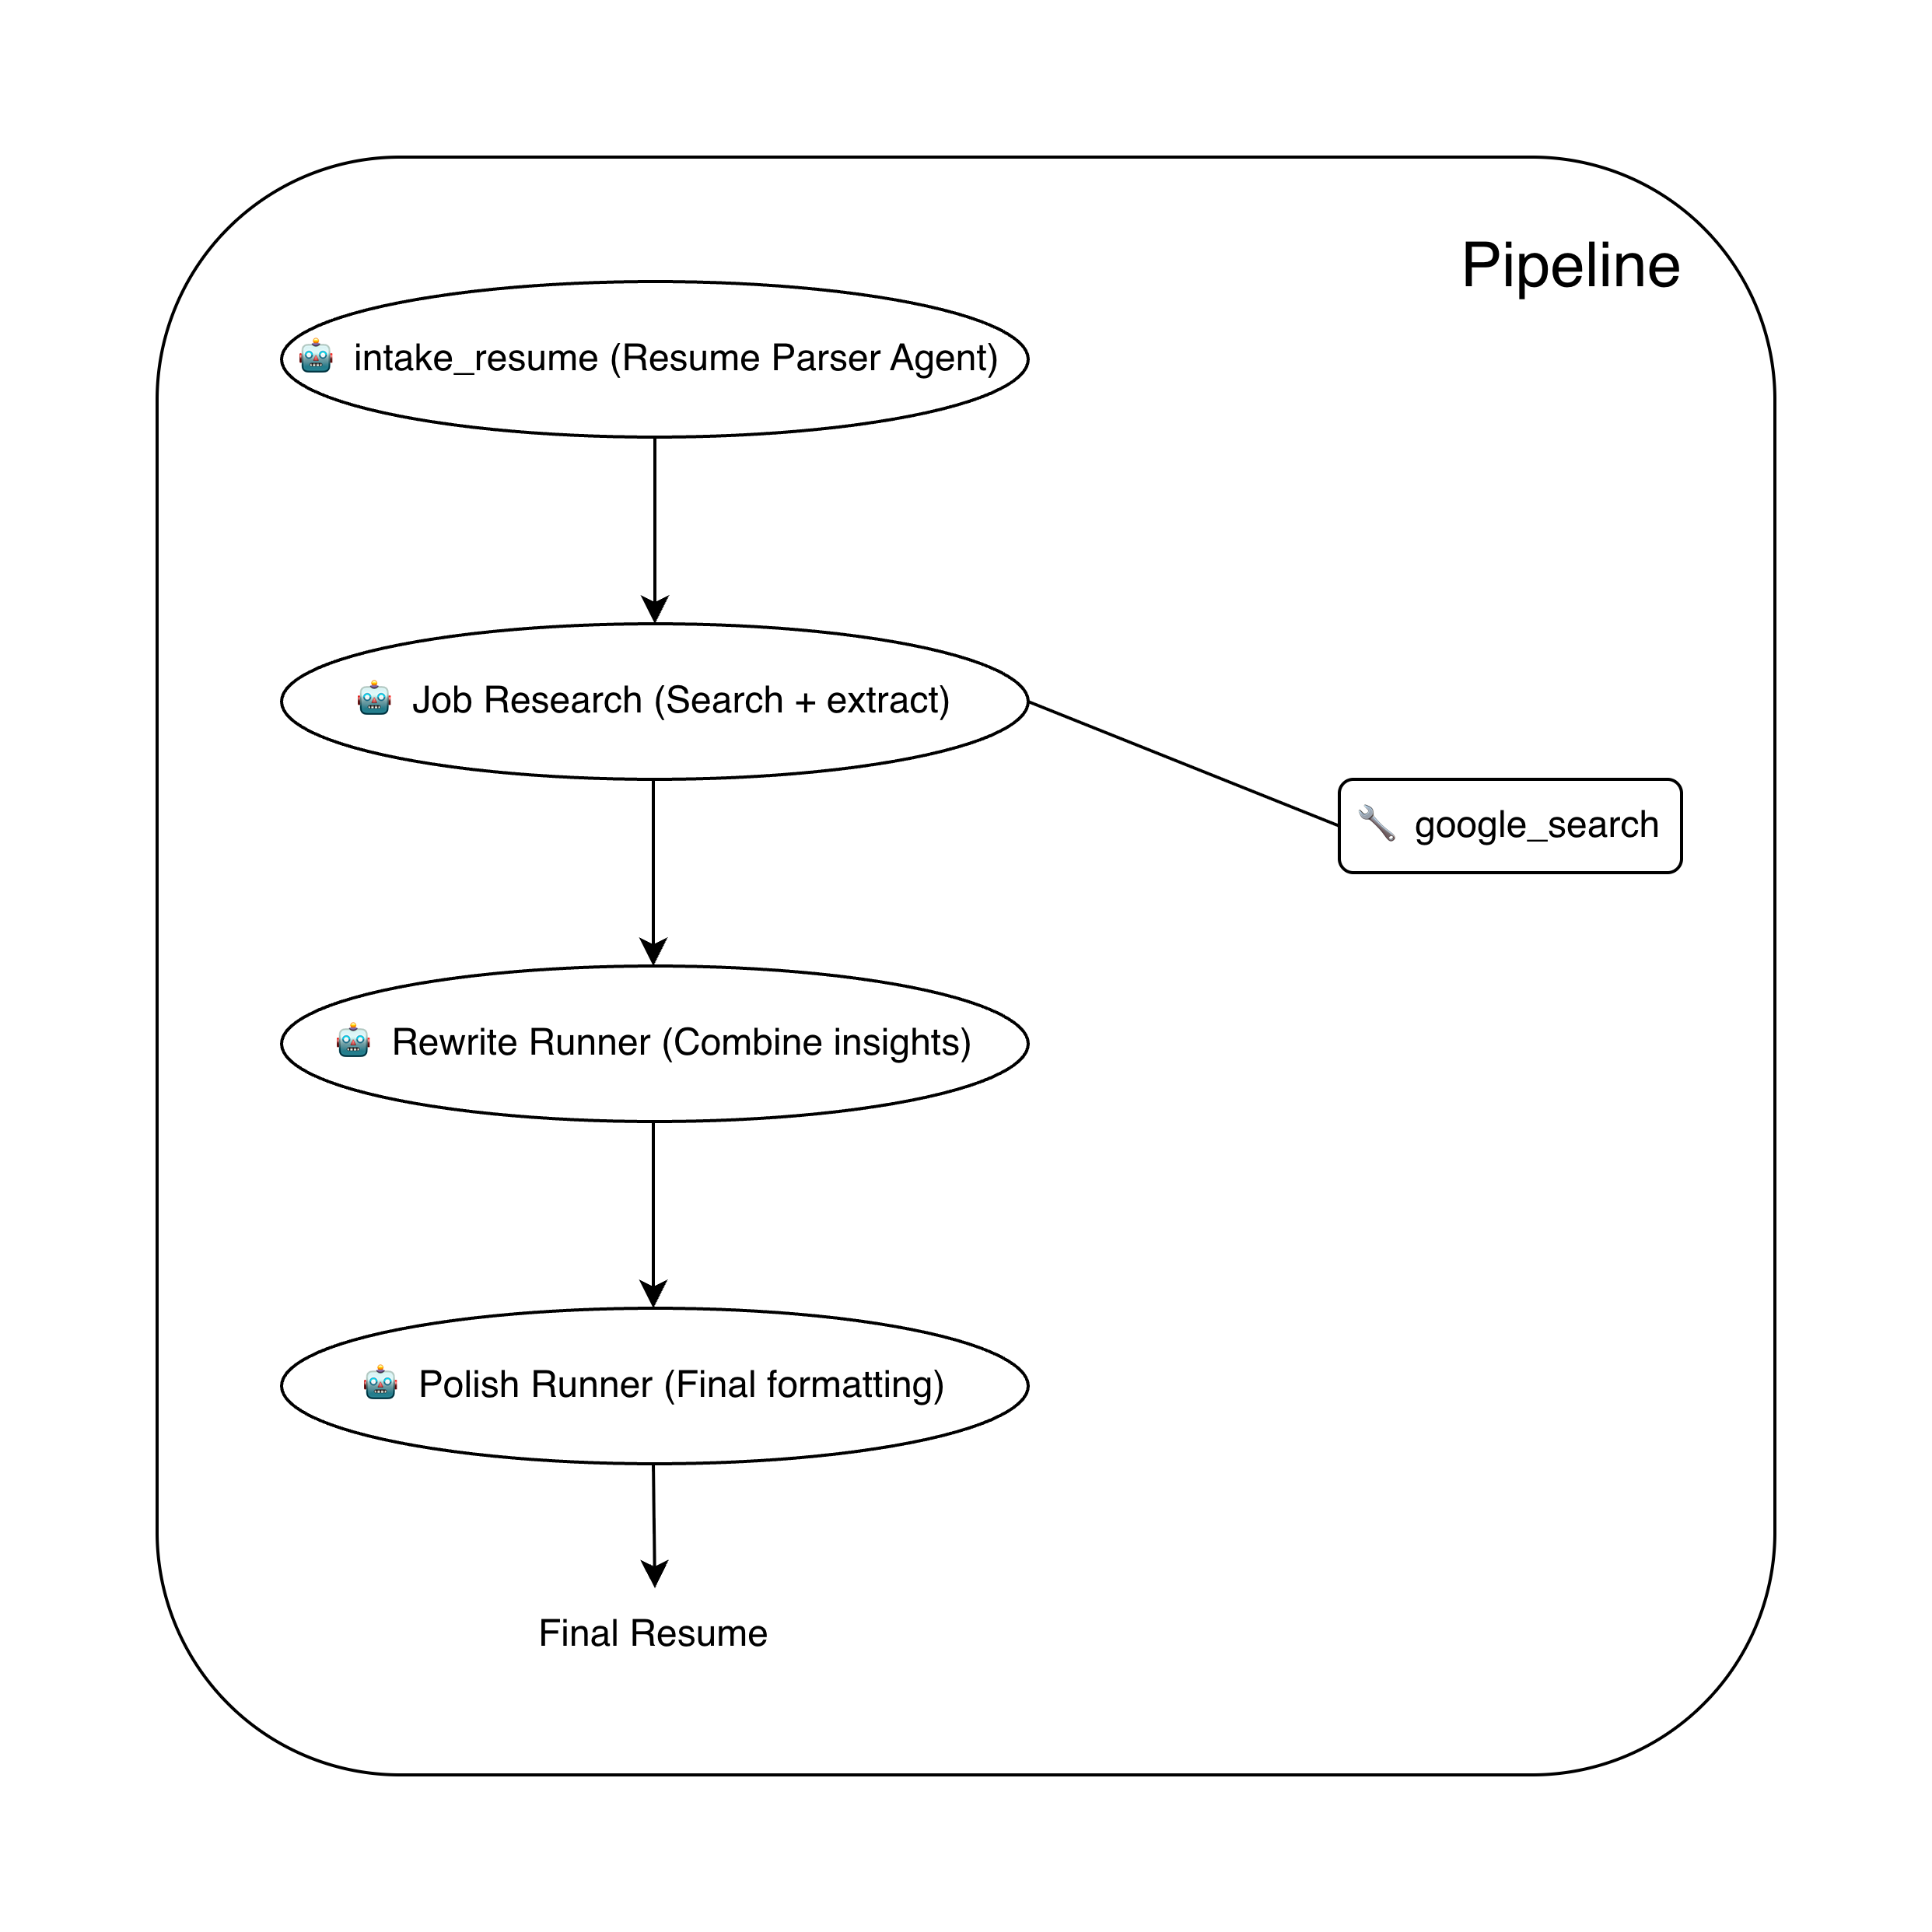

Each stage has a defined responsibility, facilitating readability, maintainability, and reproducibility. This is seen in the 'Agent Instruction' section, where each responsibility is expliclity defined.

## Features

This project demonstrates skills in:

1) **Sequential Multi-Agent Pipeline:** 4 Gemini agents (intake, research, rewrite, polish) working in a sequential and dependent flow.
2) **Built-in Tool Usage (Google Search):** Utilizes the built-in Google Search tool to gather real-world job-specific information.
3) **Context Engineering:** Each agent recieves only the necessary information it needs, enabling the prompts to include dynamic data without context overflow of the entire output.

## Project Setup

In [1]:
import os
from dotenv import load_dotenv

try:
    load_dotenv()
    GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
    os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "FALSE"
    
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(f"API Authentication Error, please make sure you have setup your .env with the correct GOOGLE_API_KEY: {e}")

✅ Gemini API key setup complete.


In [2]:
from google.adk.agents import Agent, LlmAgent
from google.adk.runners import InMemoryRunner
from google.adk.tools import google_search
from google.adk.models import Gemini
from google.adk.sessions import InMemorySessionService
from google.adk.memory import InMemoryMemoryService

print("✅ ADK components imported successfully.")

/Users/henryyost/git_testing/capstone-resume-agent/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/henryyost/git_testing/capstone-resume-agent/venv/lib/python3.9/site-packages/google/api_core/_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.6) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)


An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


MCP requires Python 3.10 or above. Please upgrade your Python version in order to use it.
MCP requires Python 3.10 or above. Please upgrade your Python version in order to use it.


✅ ADK components imported successfully.


In [3]:
import logging
import os

# Clean up any previous logs
for log_file in ["logger.log", "web.log", "tunnel.log"]:
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"🧹 Cleaned up {log_file}")

# Configure logging with DEBUG log level.
logging.basicConfig(
    filename="logger.log",
    level=logging.DEBUG,
    format="%(filename)s:%(lineno)s %(levelname)s:%(message)s",
)

print("✅ Logging configured")

🧹 Cleaned up logger.log
✅ Logging configured


In [4]:
# Automatic retries to contact the Gemini API if it fails
from google.genai import types

retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

## Agent Instructions

Each agent recieves a different set of instructions tailored to its role. This seperation is key for improving perforance, security, and manageability as we learned in the course.

In [5]:
INTAKE_INSTRUCTION = """
    Extract structured resume info (education, skills, projects, experience).
    Return bullet points without rewriting or inventing details.
"""

JOB_RESEARCH_INSTRUCTION = """
    Perform a Google search for the given job title/company.
    Summarize required skills, preferred qualifications, and responsibilities.
"""

REWRITE_INSTRUCTION = """
    Combine/restructure the parsed resume + job research.
    Rewrite the resume using strong, tailored bullet points.
    You have unlimited freedom, as long as the following conditions are met:
        1) The resume, and only the resume is stored in the "resume" JSON value.
        2) Every major action must be justified and explained in a clear and concise manner.
        3) You DO NOT invent false experiences and information.
        4) Do NOT introduce placeholders (e.g., "[Your Email]", "[Location]") when the information already exists in the provided resume. 
           - If a field is missing entirely in the original resume (e.g., no email), then and ONLY then may you use a placeholder.

Return your output ONLY as a JSON object with two fields:

{
  "resume": "<rewritten resume in Markdown>",
  "rationale": "<explanation of what was improved and why>"
}
"""

POLISH_INSTRUCTION = """
Clean, and format, the resume text in Markdown. Your goal is to ensure clarity, consistency, and professionalism exists in the document. 
You may adjust section headers, spacing, and formatting to improve readability.
"""


print("✅ Agents instructions created")

✅ Agents instructions created


## Defining Agents and Runners

In [6]:
resume_intake_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="ResumeIntakeAgent",
    instruction=INTAKE_INSTRUCTION,
    tools=[]
)

job_research_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="JobResearchAgent",
    instruction=JOB_RESEARCH_INSTRUCTION,
    tools=[google_search]
)

resume_rewrite_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="ResumeRewriteAgent",
    instruction=REWRITE_INSTRUCTION,
    tools=[]
)

polish_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="PolishAgent",
    instruction=POLISH_INSTRUCTION,
    tools=[]
)

# Defining Runners used in Pipeline
intake_runner = InMemoryRunner(resume_intake_agent)
job_runner = InMemoryRunner(job_research_agent)
rewrite_runner = InMemoryRunner(resume_rewrite_agent)
polish_runner = InMemoryRunner(polish_agent)

print("✅ Agents + Runners created")

✅ Agents + Runners created


## Multi-Agent Pipeline
### Helper functions

In [7]:
import contextlib
import io
import json
import re
from IPython.display import Markdown, display

def validate_output(output: str, stage: str):
    """
    verifies the output from the model is an instance of str or not empty, otherwise raise an error
    with the stage (for debugging).
    """
    if not output or not isinstance(output, str):
        raise ValueError(f"❌ {stage} returned empty or invalid content.")


# This function `extract_resume_and_rationale` was drafted using AI.
def extract_resume_and_rationale(text: str):
    """
    Safely extract JSON from model output. Returns dict with 'resume' and 'rationale'.
    """
    # Remove markdown fences
    cleaned = re.sub(r"```(?:json|markdown)?", "", text).strip()

    # Find first JSON object
    match = re.search(r"\{[\s\S]*\}", cleaned)
    if not match:
        return {
            "resume": "Failed to parse JSON from model output.",
            "rationale": text
        }

    json_str = match.group(0)
    try:
        data = json.loads(json_str)
        return {
            "resume": data.get("resume", "").strip(),
            "rationale": data.get("rationale", "").strip()
        }
    except json.JSONDecodeError:
        return {
            "resume": "Failed to parse JSON from model output.",
            "rationale": cleaned
        }


def display_markdown(text: str, title: str = None):
    """
    Safely displays the title + text in markdown format in notebook style editor(s). 
    """
    header = f"## {title}\n\n" if title else ""
    display(Markdown(header + text))

# If you want to see the agents output from debug, feel free to replace all instances `silent_run_debug` with `run_debug`
async def silent_run_debug(runner, text):
    """
    Runs a runner in debug mode safely, capturing only text outputs.
    This was created to prevent sensitive data from getting printed in the demo.
    """
    buffer = io.StringIO()
    with contextlib.redirect_stdout(buffer):
        events = await runner.run_debug(text)

    last_text = None

    for event in events:
        if hasattr(event, "content") and event.content:
            parts = event.content.parts
            if parts and hasattr(parts[0], "text"):
                last_text = parts[0].text # grab last text, as that's the models generated text.

    return last_text

### Agent Pipeline

In [8]:
async def agent_pipeline(resume_text: str, job_query: str):
    # Validate inputs, otherwise throw error.
    if not resume_text.strip():
        raise ValueError("Resume text cannot be empty.")
    if not job_query.strip():
        raise ValueError("Job query cannot be empty.")

    # run the intake runner, and validate the output
    intake_output = await silent_run_debug(intake_runner, resume_text)
    validate_output(intake_output, "Intake Runner")

    
    # run the job researching agent, and validate the output is of correct type. 
    job_output = await silent_run_debug(job_runner, job_query)
    validate_output(job_output, "Job Runner")


    # the prompt with the proper context for the rewrite agent, giving access to `intake_output`, and `job_output`. 
    rewrite_prompt = f"""
        Parsed resume:
        {intake_output}
        
        Job research:
        {job_output}
        
        Rewrite the resume using BOTH as context. Output ONLY JSON as per instructions.
    """

    # run the rewrite agent, and validate the output is of correct type. 
    rewrite_output = await silent_run_debug(rewrite_runner, rewrite_prompt)
    validate_output(rewrite_output, "Rewrite Runner")

    # Parse JSON output with `extract_resume_and_rational` function.  
    parsed = extract_resume_and_rationale(rewrite_output)


    # run the polish agent only on the parsed["resume"] of the JSON obj. 
    polished_resume_raw = await silent_run_debug(polish_runner, parsed["resume"])

    # Clean markdown fences + formatting to prevent verbatim printing of markdown formatting.
    polished_resume_clean = re.sub(r"```(?:markdown)?", "", polished_resume_raw or "").strip()
    validate_output(polished_resume_clean, "Polish Runner")

    # Return structured output, giving us all the information from the agent pipeline fuction. 
    return {
        "intake": intake_output,
        "job_research": job_output,
        "parsed_resume": polished_resume_clean,
        "parsed_rationale": parsed["rationale"]
    }

print("✅ Pipeline + helper functions created")

✅ Pipeline + helper functions created


### Test Example + Demo

In [9]:
from pathlib import Path
from IPython.display import Markdown, display

# Note: Change this path to your own path when using your own resume.txt.
# Loading in the demo resume.
resume_path = Path("data/alex_carter_demo_resume.txt")

if not resume_path.is_file():
    raise FileNotFoundError(f"No valid resume file found at {resume_path.resolve()}")

with open(resume_path, "r") as file:
    resume_text = file.read()

# grab job position from user as an input.
job_query = input("Enter a job (e.g., 'Tesla SWE Intern 2026'): ")

# run the pipeline, and finally display the results.
result = await agent_pipeline(resume_text, job_query)
display_markdown(result["parsed_resume"], title="Polished Resume")

Enter a job (e.g., 'Tesla SWE Intern 2026'):  GOOGLE SWE Intern 2026


## Polished Resume

Absolutely! Here's the cleaned and formatted resume in Markdown, with adjustments for clarity and professionalism:


# [Your Name]
[Your Phone Number] | [Your Email] | [Your LinkedIn Profile URL] | [Your GitHub Profile URL]

---

## Summary

Highly motivated Computer Science student at UC San Diego (expected June 2026) with a strong foundation in data structures, algorithms, and machine learning. Proven ability to design, develop, and deploy scalable software solutions through academic projects and a software engineering internship. Eager to leverage skills in Python, Java, C++, and ML frameworks to contribute to impactful projects in a challenging internship role.

---

## Education

**University of California, San Diego** – La Jolla, CA
*   **Bachelor of Science in Computer Science**, Expected June 2026
*   **Relevant Coursework:** Data Structures & Algorithms, Machine Learning, Operating Systems, Database Systems, Software Engineering

---

## Experience

**Software Engineering Intern** | Horizon Analytics – [City, State]
*June 2024 – September 2024*

*   Developed and implemented critical data processing modules for a high-throughput telemetry monitoring platform, handling over 30,000 events per second.
*   Engineered Python ETL jobs that optimized data ingestion and transformation, contributing to a 15% overall performance improvement in data processing pipelines.
*   Designed and integrated automated integration tests using `pytest` and GitHub Actions, enhancing code quality and deployment reliability.

---

## Projects

**SmartTransit** | Python, PyTorch, TensorFlow, Docker
*   Developed a real-time bus arrival prediction model utilizing LSTM networks, achieving an 18% increase in prediction accuracy.
*   Engineered a robust data processing pipeline to clean, merge, and process over 2 million GPS data points from a public transit dataset.
*   Containerized the entire prediction system using Docker, enabling seamless and scalable deployment.

**PixelForge** | React, Node.js, MongoDB, WebSockets
*   Built a full-stack collaborative drawing platform featuring real-time canvas synchronization via WebSockets, supporting multiple concurrent users.
*   Implemented a secure role-based access control system and persistent project storage using MongoDB.
*   Optimized frontend performance by 30% through the strategic implementation of code splitting and caching techniques.

**GPU Weather Simulator** | C++, CUDA
*   Accelerated a fluid-dynamics-based weather simulation by 12x through the development of custom CUDA kernels for GPU parallelization.
*   Designed and implemented memory-optimized CUDA kernels for computationally intensive particle advection and temperature diffusion processes.

---

## Skills

*   **Programming Languages:** Python, Java, C++, SQL, JavaScript
*   **Frameworks & Libraries:** PyTorch, TensorFlow, React, Node.js, Flask
*   **Tools & Technologies:** Docker, Git, GitHub Actions, CUDA, WebSockets
*   **Concepts:** Machine Learning, REST APIs, Distributed Systems, Data Pipelines, Algorithms, Data Structures

---

## Leadership & Activities

**Project Team Lead** | Computer Science Society – UC San Diego
*   Led a team of 6 students in the development of a campus navigation application with advanced indoor routing capabilities.
*   Facilitated project progression through structured weekly stand-ups, comprehensive roadmap planning, and rigorous code reviews.

**Winner (1st Place)** | SD Hacks 2024
*   Developed a wildfire-risk prediction dashboard leveraging satellite imagery, demonstrating rapid prototyping and effective application of ML in a hackathon setting.

---

## Languages

*   English (Fluent)
*   Spanish (Conversational)

## Entire Report for the Test Example

In [10]:
# Markdown formatting for the entire pipeline
display_markdown(f"""
# Pipeline Explanation

### Intake Summary  
---
{result['intake']}

### Job Insights Summary  
---
{result['job_research']}

### Agent's Rewrite Rationale  
---
{result['parsed_rationale']}
""")


# Pipeline Explanation

### Intake Summary  
---
**Education**

*   University of California, San Diego
    *   B.S. in Computer Science, Expected June 2026
    *   Relevant Coursework: Data Structures & Algorithms, Machine Learning, Operating Systems, Database Systems, Software Engineering

**Skills**

*   Languages: Python, Java, C++, SQL, JavaScript
*   Tools & Frameworks: PyTorch, TensorFlow, React, Node.js, Flask, Docker, Git
*   Concepts: Machine Learning, REST APIs, Distributed Systems, Data Pipelines

**Projects**

*   SmartTransit (Python, ML)
    *   Built a real-time bus arrival prediction model using LSTM networks, improving prediction accuracy by 18%.
    *   Designed a pipeline to clean, merge, and process 2M+ GPS datapoints from a public transit dataset.
    *   Containerised the entire system using Docker to support scalable deployment.
*   PixelForge (React, Node.js)
    *   Developed a full-stack collaborative drawing platform with real-time canvas syncing over WebSockets.
    *   Implemented role-based access control and persistent project saving with MongoDB.
    *   Improved frontend load performance by 30% via code splitting and caching.
*   GPU Weather Simulator (C++, CUDA)
    *   Accelerated fluid-dynamics-based weather simulation by 12× using CUDA kernels.
    *   Wrote custom memory-optimised kernels for particle advection and temperature diffusion.

**Experience**

*   Software Engineering Intern — Horizon Analytics (June 2024 – September 2024)
    *   Implemented data processing modules for a telemetry monitoring platform ingesting 30K+ events/sec.
    *   Wrote Python ETL jobs responsible for 15% overall speed improvement.
    *   Built automated integration tests using pytest and GitHub Actions.

**Leadership & Activities**

*   Computer Science Society — Project Team Lead
    *   Led a 6-student team developing a campus navigation app with indoor routing.
    *   Managed weekly standups, roadmap planning, and code reviews.
*   Hackathons
    *   Winner (1st Place), SD Hacks 2024 — built a wildfire-risk prediction dashboard using satellite imagery.

**Additional**

*   Strong interests in ML engineering, distributed systems, and large-scale backend systems.
*   Fluent in English and conversational in Spanish.

### Job Insights Summary  
---
## Google SWE Intern 2026: Key Details and Qualifications

Google is seeking highly motivated students for its Software Engineering Internship program in Summer 2026. This 10-12 week paid internship offers hands-on experience working on real-world projects that impact millions of users globally.

### Responsibilities:

Interns will collaborate with full-time engineers on various aspects of software development, including:
*   Designing, developing, testing, and debugging software applications.
*   Writing, testing, and debugging code in various programming languages.
*   Participating in design discussions and code reviews.
*   Collaborating with cross-functional teams, including product managers and UX designers.
*   Learning and applying Google's engineering best practices.
*   Researching, creating, and developing software applications to enhance Google's product offerings.
*   Contributing to projects involving areas such as natural language processing, artificial intelligence, data compression, machine learning, and search technologies.
*   Addressing scalability issues related to large amounts of data and information.

### Minimum Qualifications:

*   Currently enrolled in a Bachelor's, Master's, or PhD program in Computer Science, Computer Engineering, or a closely related technical field.
*   Strong foundation in programming languages such as C++, Java, Python, or Go.
*   Experience working in Unix/Linux environments.
*   Demonstrated skills in algorithms, data structures, software design, and problem-solving.
*   Expected to graduate after the internship period (typically between December 2026 and 2027).
*   English proficiency to actively participate in technical discussions.

### Preferred Qualifications:

*   Enrolled in a full-time Master's or PhD program.
*   Experience or interest in specific areas such as:
    *   Web application development
    *   Mobile application development
    *   Distributed and parallel systems
    *   Information retrieval
    *   Natural language processing (NLP)
    *   Machine learning
    *   Networking
    *   Developing large software systems
    *   Security software development
    *   Artificial Intelligence
    *   Architecture
    *   Compilers
    *   Database
    *   Data Mining
    *   Systems
*   Ability to showcase personal or academic tech projects and participate in computer science-related extracurricular activities.
*   Experience with competitive programming or contributions to open-source projects.

### Application and Timing:

The application window is typically open until December of the preceding year (e.g., December 2025 for Summer 2026), but may close earlier if all positions are filled. Applications are reviewed on a rolling basis, so early application is encouraged. Applicants will need to submit an updated CV/resume and a current unofficial or official transcript in English. The internship typically runs for 10-12 weeks during the summer.

### Agent's Rewrite Rationale  
---
The resume has been rewritten to align with the Google SWE Intern 2026 job description, emphasizing skills and experiences relevant to their requirements. Here's a breakdown of the changes:

1.  **Summary Section Added:** A concise summary was added at the beginning to immediately highlight key qualifications, education, and career aspirations, directly addressing the "highly motivated students" and "hands-on experience" aspects mentioned in the job description. It also explicitly mentions skills like Python, Java, C++, and ML, which are listed as important by Google.

2.  **Quantifiable Achievements:** Bullet points across 'Experience' and 'Projects' sections have been rephrased to include specific, quantifiable results (e.g., "improving prediction accuracy by 18%", "15% overall speed improvement", "accelerated... by 12x", "Improved frontend load performance by 30%"). This demonstrates impact and aligns with Google's focus on measurable results.

3.  **Tailored Keywords:** Keywords from the job description such as "data structures," "algorithms," "machine learning," "distributed systems," "scalable deployment," "testing," "debugging," "real-time," and "data processing" have been integrated naturally into the bullet points. This improves the resume's compatibility with Applicant Tracking Systems (ATS) and directly addresses Google's preferred qualifications and responsibilities.

4.  **Project Descriptions Enhanced:** Project descriptions now more explicitly mention the technologies used and the problems solved, making it clearer how these projects relate to areas like "developing large software systems," "machine learning," and "web application development" (PixelForge aligns with this).

5.  **Experience Section Strengthened:** The 'Software Engineering Intern' experience at Horizon Analytics has been detailed with specific contributions, using stronger action verbs and highlighting the scale of data handled and performance improvements achieved, directly resonating with Google's need for interns who can address "scalability issues related to large amounts of data."

6.  **Skills Section Restructured:** The 'Skills' section is categorized for better readability, separating programming languages from frameworks, tools, and concepts. This makes it easier for recruiters to quickly identify relevant technical proficiencies. Specific mention of "Unix/Linux environments" is implicitly covered by Git and Docker, and the core languages requested are present.

7.  **Leadership & Activities Highlighted:** The 'Leadership & Activities' section now clearly calls out the 'Project Team Lead' role and the hackathon win. This showcases initiative, teamwork, and practical application of skills, aligning with Google's preference for "personal or academic tech projects and extracurricular activities."

8.  **Conciseness and Clarity:** Overall, the language has been refined to be more direct, professional, and impactful, removing any redundancy and ensuring each point adds value.

9.  **Placeholders:** Placeholders for contact information have been added as they were missing in the parsed resume. Contact information like LinkedIn and GitHub are crucial for SWE roles and were not present in the original input.


## Conclusion

This project is a showcase of how LLM-driven agents are able to collaborate in a sequential way to perform editing, research, and rewriting workflows. By combining sequential multi-agent orchestration, google search tool, context engineering, and structured outputs/extraction, the pipeline produces a job-aligned resume with a reproducible structure.

### What I Learned?

In this capstone project, I learned more about the Agent Development Kit (ADK), and how to best implement and apply the skills and knowledge I've gained from the intensive AI Agents course. Specifically, I feel like I learned a lot when it came to debugging the models, as that was the most time consuming part, where I really had to understand what I was working with. 

While building out this project, I faced numerous challenges, including the best way to implement the goal itself, and also writing agent instructions. I've absolutely learned the value of AI Agents, however, I've also noticed that they can be limited if not given extremely good instructions. Throughout my numerous iterations of the project, I noticed how different instructions (more freedom/restrictive) would completely change the outcome of the polished resume. Even a small tweak, could be taken very literal, which would impact the end result. This taught me a lot about context engineering, and also how best to write instructions that promote creativity, flexibility, without hallucinating.

### Future Improvements

Future potential improvements would be to add long-term memory support to store multiple tailored resumes. This would be valuable, because it would give the agent a larger window of context of the users skills that might lie beyond what they've initially given. 

Additionally, I want to deploy the system as an API-driven service, as this could make it much more efficient and scalable solution to the problem.